# Linear Regression Model Analysis for Stock Price Prediction

This notebook analyzes and addresses issues with a linear regression model used for predicting stock price levels. We'll explore alternative approaches and validation techniques to improve model performance.

## Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load and Inspect Data

In [2]:
# Load the dataset
# Note: Replace 'stock_data.csv' with your actual file path
try:
    df = pd.read_csv('stock_data.csv')
except FileNotFoundError:
    # If file not found, create sample data for demonstration
    np.random.seed(42)
    dates = pd.date_range(start='2020-01-01', periods=500)
    price = 100 + np.cumsum(np.random.normal(0, 1, 500))
    df = pd.DataFrame({
        'Date': dates,
        'Close': price,
        'Volume': np.random.randint(1000000, 10000000, 500)
    })

# Convert Date to datetime if not already
if df['Date'].dtype != 'datetime64[ns]':
    df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df = df.set_index('Date')

# Display the first few rows
print("Dataset head:")
print(df.head())

# Display dataset info
print("\nDataset info:")
print(df.info())

# Display summary statistics
print("\nSummary statistics:")
print(df.describe())

Dataset head:
                 Close   Volume
Date                           
2020-01-01  100.496714  6952793
2020-01-02  100.358450  9961343
2020-01-03  101.006138  3000609
2020-01-04  102.529168  3697143
2020-01-05  102.295015  2314532

Dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2020-01-01 to 2021-05-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   500 non-null    float64
 1   Volume  500 non-null    int32  
dtypes: float64(1), int32(1)
memory usage: 9.8 KB
None

Summary statistics:
            Close        Volume
count  500.000000  5.000000e+02
mean    98.627702  5.668885e+06
std      7.019452  2.628714e+06
min     86.473055  1.064323e+06
25%     92.072446  3.474914e+06
50%     98.896994  5.647054e+06
75%    104.425112  7.966580e+06
max    115.635646  9.997354e+06
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2020-01-01 to 2021-05-14
Data columns (total 2

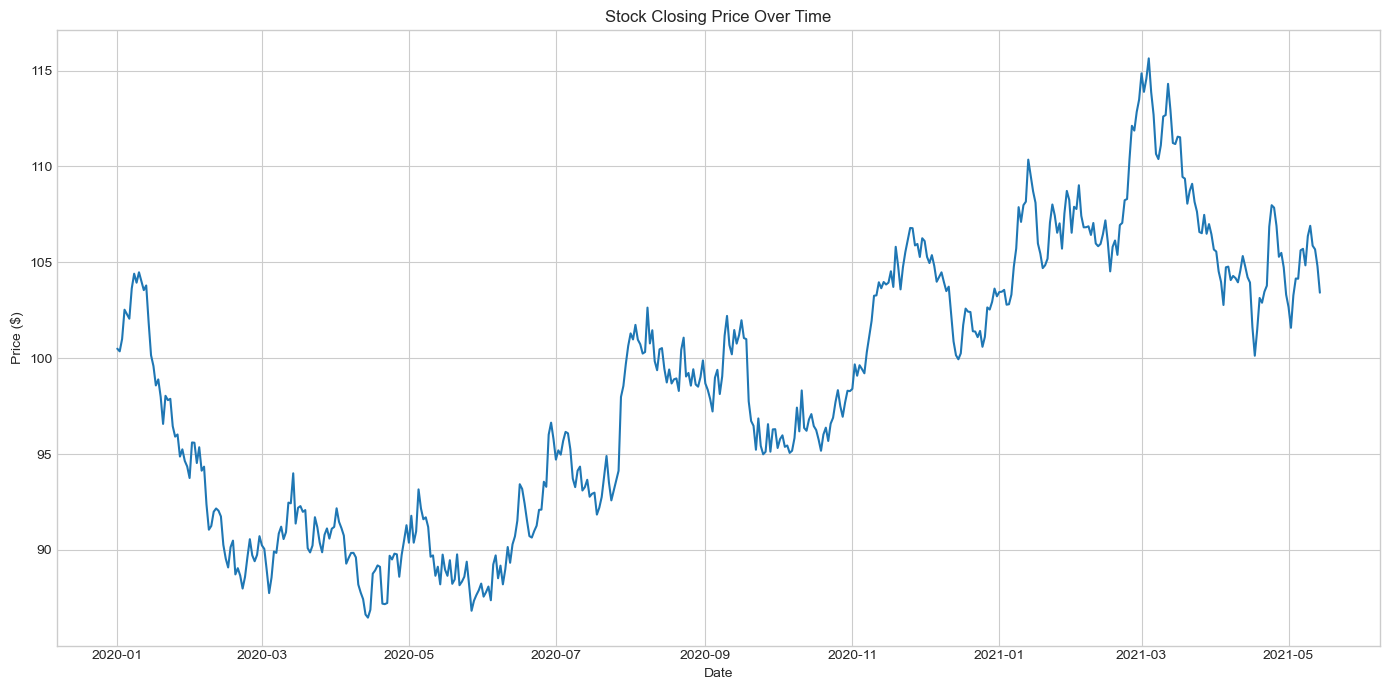


Missing values in each column:
Close     0
Volume    0
dtype: int64


In [3]:
# Visualize the closing prices
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

## Baseline Persistence Model

We'll start with a simple baseline model that predicts tomorrow's price as today's price.

Baseline Persistence Model Performance:
RMSE: 0.9810
R²: 0.9805
MAE: 0.7798


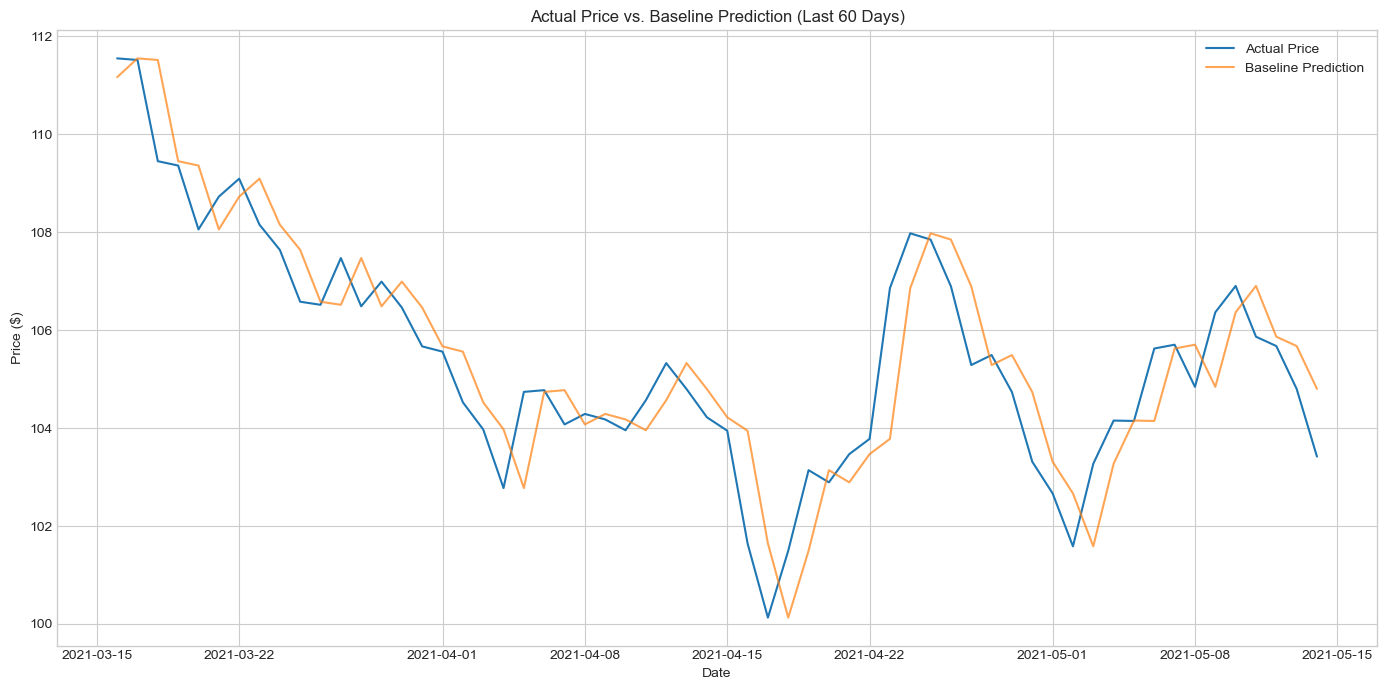

In [4]:
# Create a shifted version of the 'Close' column to represent the baseline prediction
df['Baseline_Prediction'] = df['Close'].shift(1)

# Remove the first row which has NaN due to shifting
df_baseline = df.dropna()

# Calculate baseline model errors
baseline_rmse = np.sqrt(mean_squared_error(df_baseline['Close'], df_baseline['Baseline_Prediction']))
baseline_r2 = r2_score(df_baseline['Close'], df_baseline['Baseline_Prediction'])
baseline_mae = mean_absolute_error(df_baseline['Close'], df_baseline['Baseline_Prediction'])

print(f"Baseline Persistence Model Performance:")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"R²: {baseline_r2:.4f}")
print(f"MAE: {baseline_mae:.4f}")

# Visualize actual vs baseline prediction
plt.figure(figsize=(14, 7))
plt.plot(df_baseline.index[-60:], df_baseline['Close'][-60:], label='Actual Price')
plt.plot(df_baseline.index[-60:], df_baseline['Baseline_Prediction'][-60:], label='Baseline Prediction', alpha=0.7)
plt.title('Actual Price vs. Baseline Prediction (Last 60 Days)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Predict Daily Returns Instead of Price

One of the key issues with predicting price levels directly is that they are often non-stationary. 
Let's transform our target to predict daily returns instead of price levels.

In [5]:
# Calculate daily returns
df['Returns'] = df['Close'].pct_change()

# Create features (previous day returns)
df['Prev_Returns'] = df['Returns'].shift(1)

# Optional: Add more lagged returns as features
for i in range(2, 6):
    df[f'Prev_Returns_{i}'] = df['Returns'].shift(i)

# Add other potential features
df['Prev_Volume'] = df['Volume'].shift(1)
df['Volume_Change'] = df['Volume'].pct_change()

# Remove rows with NaN values
df_returns = df.dropna()

# Display the first few rows of the prepared dataset
print("Dataset with returns features:")
print(df_returns.head())

# Check stationarity of returns vs price
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f"{title} - ADF Statistic: {result[0]:.4f}")
    print(f"{title} - p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")

print("\nStationarity Tests:")
check_stationarity(df['Close'], "Price Levels")
check_stationarity(df['Returns'], "Daily Returns")

Dataset with returns features:
                 Close   Volume  Baseline_Prediction   Returns  Prev_Returns  \
Date                                                                           
2020-01-07  103.640091  1944789           102.060878  0.015473     -0.002289   
2020-01-08  104.407525  3213573           103.640091  0.007405      0.015473   
2020-01-09  103.938051  9914501           104.407525 -0.004497      0.007405   
2020-01-10  104.480611  3255363           103.938051  0.005220     -0.004497   
2020-01-11  104.017193  9375741           104.480611 -0.004435      0.005220   

            Prev_Returns_2  Prev_Returns_3  Prev_Returns_4  Prev_Returns_5  \
Date                                                                         
2020-01-07       -0.002284        0.015079        0.006454       -0.001376   
2020-01-08       -0.002289       -0.002284        0.015079        0.006454   
2020-01-09        0.015473       -0.002289       -0.002284        0.015079   
2020-01-10        

Returns-based Linear Regression Model Performance:
Train RMSE: 0.009943, Test RMSE: 0.009973
Train R²: 0.0156, Test R²: -0.0276

Reconstructed Price Prediction Performance:
RMSE: 4.0593
R²: -0.3891


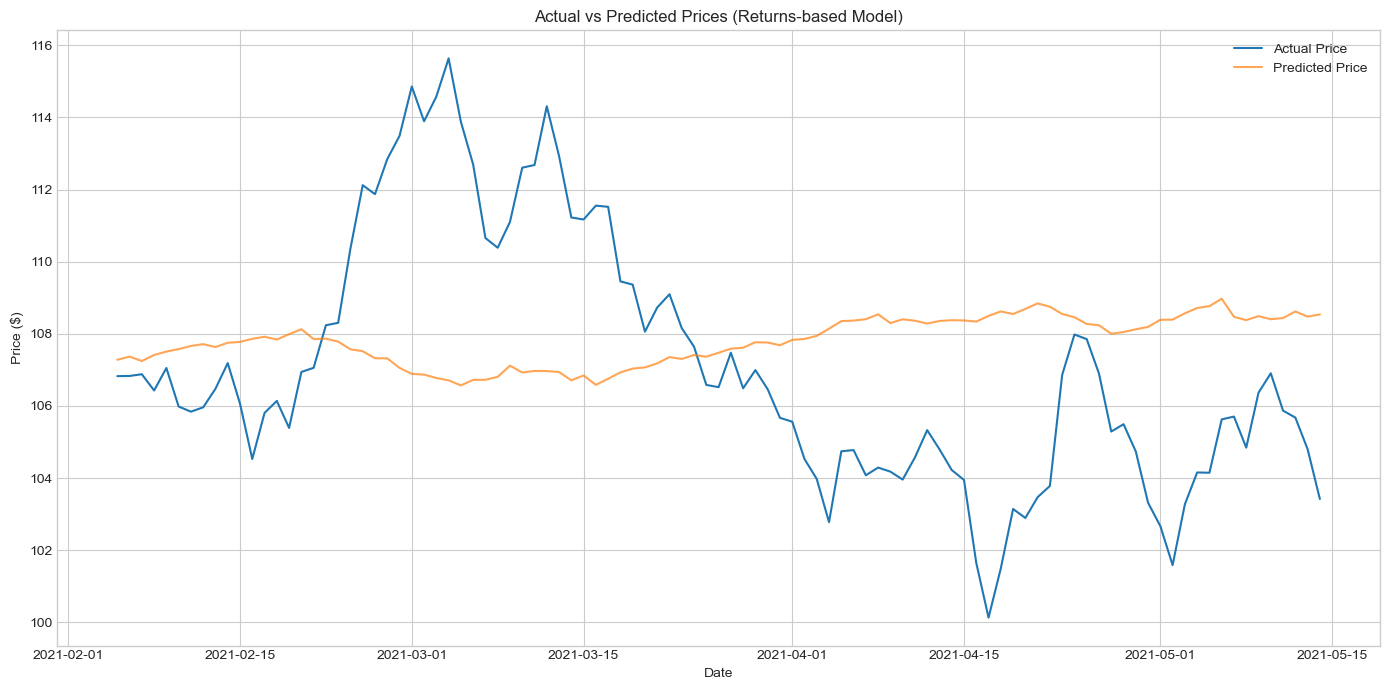

In [6]:
# Function to create features and target for returns-based model
def create_features_target(data, target_col='Returns', feature_cols=None):
    if feature_cols is None:
        feature_cols = ['Prev_Returns', 'Prev_Returns_2', 'Prev_Returns_3', 
                       'Prev_Returns_4', 'Prev_Returns_5', 'Prev_Volume', 'Volume_Change']
    
    # Ensure all required columns exist
    available_cols = [col for col in feature_cols if col in data.columns]
    X = data[available_cols]
    y = data[target_col]
    
    return X, y

# Create features and target
X, y = create_features_target(df_returns)

# Split data into train and test sets (using a simple time-based split for illustration)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train a linear regression model on returns
model_returns = LinearRegression()
model_returns.fit(X_train, y_train)

# Make predictions
y_train_pred = model_returns.predict(X_train)
y_test_pred = model_returns.predict(X_test)

# Calculate metrics for returns prediction
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Returns-based Linear Regression Model Performance:")
print(f"Train RMSE: {train_rmse:.6f}, Test RMSE: {test_rmse:.6f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

# Convert returns predictions back to price predictions for comparison
# Initialize arrays
test_dates = df_returns.index[train_size:]
actual_prices = df_returns['Close'][train_size:].values
predicted_prices = np.zeros(len(test_dates))

# First predicted price is the last known price times (1 + predicted return)
predicted_prices[0] = df_returns['Close'][train_size-1] * (1 + y_test_pred[0])

# Calculate the rest of the predicted prices
for i in range(1, len(predicted_prices)):
    predicted_prices[i] = predicted_prices[i-1] * (1 + y_test_pred[i])

# Calculate RMSE and R² on the reconstructed prices
price_rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
price_r2 = r2_score(actual_prices, predicted_prices)

print("\nReconstructed Price Prediction Performance:")
print(f"RMSE: {price_rmse:.4f}")
print(f"R²: {price_r2:.4f}")

# Visualize actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(test_dates, actual_prices, label='Actual Price')
plt.plot(test_dates, predicted_prices, label='Predicted Price', alpha=0.7)
plt.title('Actual vs Predicted Prices (Returns-based Model)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Walk-Forward Validation

Now let's implement walk-forward validation, which is more appropriate for time series data.
This approach retrains the model on an expanding window and makes predictions for the next k days.

In [7]:
def walk_forward_validation(data, feature_cols, target_col, initial_train_size, step=1, forecast_horizon=1):
    """
    Perform walk-forward validation for time series forecasting
    
    Parameters:
    data (DataFrame): The dataset with features and target
    feature_cols (list): List of feature column names
    target_col (str): Target column name
    initial_train_size (int): Size of initial training set
    step (int): How many steps to move forward in each iteration
    forecast_horizon (int): How many steps ahead to forecast
    
    Returns:
    tuple: Lists of actual values and predictions
    """
    actuals = []
    predictions = []
    
    # Ensure we have sufficient data for validation
    if len(data) <= initial_train_size + forecast_horizon:
        raise ValueError("Insufficient data for walk-forward validation")
    
    # Walk forward over the dataset
    for i in range(initial_train_size, len(data) - forecast_horizon + 1, step):
        # Extract train data (all data up to current point)
        train_data = data.iloc[:i]
        X_train = train_data[feature_cols]
        y_train = train_data[target_col]
        
        # Train model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Extract test data (next forecast_horizon points)
        test_data = data.iloc[i:i+forecast_horizon]
        X_test = test_data[feature_cols]
        y_test = test_data[target_col]
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Store actuals and predictions
        actuals.extend(y_test.values)
        predictions.extend(y_pred)
        
        # Optional: Print progress
        if i % (10 * step) == 0:
            print(f"Processing point {i}/{len(data)}")
    
    return actuals, predictions

# Apply walk-forward validation
# Define feature columns
feature_cols = ['Prev_Returns', 'Prev_Returns_2', 'Prev_Returns_3', 
                'Prev_Volume', 'Volume_Change']

# Ensure all required columns exist
available_cols = [col for col in feature_cols if col in df_returns.columns]

# Define parameters for walk-forward validation
initial_train_size = int(0.6 * len(df_returns))
step = 5  # Retrain model every 5 days
forecast_horizon = 1  # Predict 1 day ahead

# Perform walk-forward validation
print(f"Starting walk-forward validation with initial train size of {initial_train_size}")
actuals, predictions = walk_forward_validation(
    df_returns, available_cols, 'Returns', initial_train_size, step, forecast_horizon
)

# Calculate metrics
wf_rmse = np.sqrt(mean_squared_error(actuals, predictions))
wf_r2 = r2_score(actuals, predictions)
wf_mae = mean_absolute_error(actuals, predictions)

print("\nWalk-Forward Validation Results (Returns):")
print(f"RMSE: {wf_rmse:.6f}")
print(f"R²: {wf_r2:.4f}")
print(f"MAE: {wf_mae:.6f}")

Starting walk-forward validation with initial train size of 296

Walk-Forward Validation Results (Returns):
RMSE: 0.009551
R²: -0.1308
MAE: 0.007624



Walk-Forward Validation Results (Reconstructed Prices):
RMSE: 0.7627
R²: 0.9218


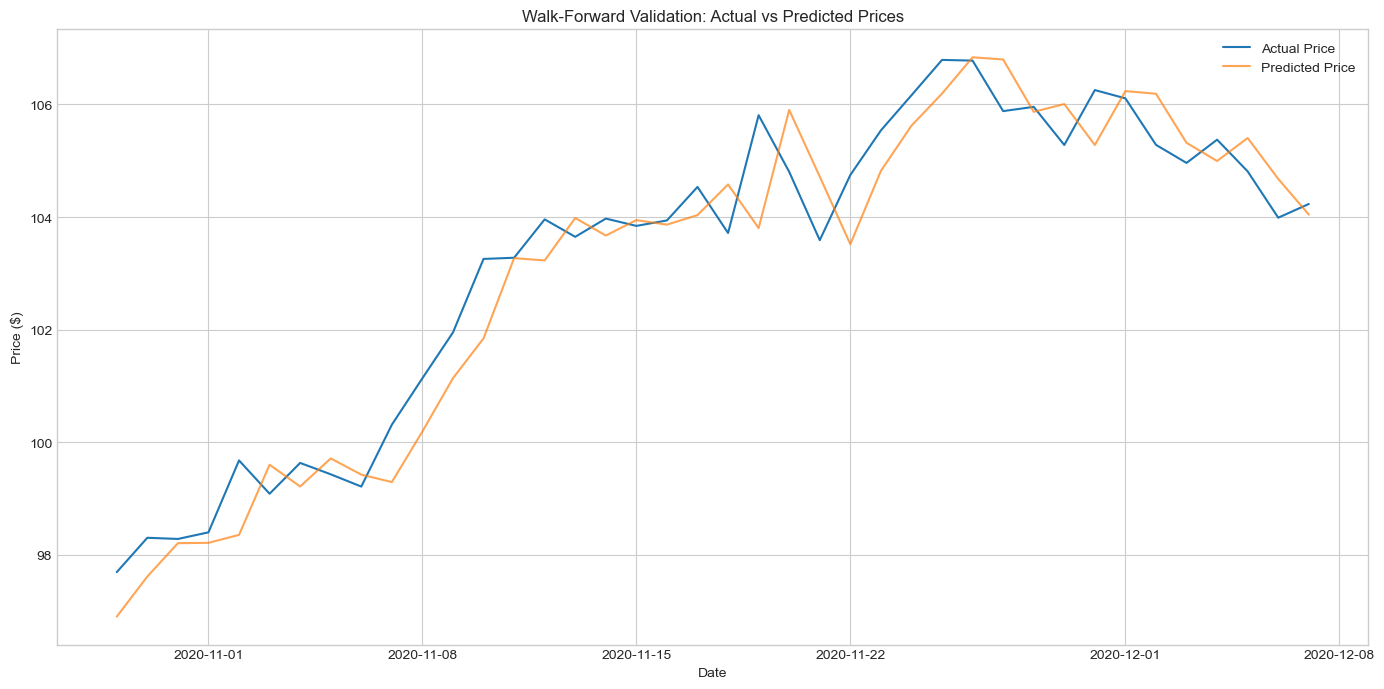

In [8]:
# Convert returns predictions to price predictions
test_indices = df_returns.index[initial_train_size:initial_train_size+len(actuals)]
actual_prices = df_returns.loc[test_indices, 'Close'].values

# Initialize predicted prices with the last known price
predicted_prices = np.zeros(len(actuals))
last_price = df_returns['Close'].iloc[initial_train_size-1]

# Calculate predicted prices
for i in range(len(predictions)):
    predicted_price = last_price * (1 + predictions[i])
    predicted_prices[i] = predicted_price
    last_price = actual_prices[i]  # Use actual price as base for next prediction

# Calculate metrics on the reconstructed prices
wf_price_rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
wf_price_r2 = r2_score(actual_prices, predicted_prices)

print("\nWalk-Forward Validation Results (Reconstructed Prices):")
print(f"RMSE: {wf_price_rmse:.4f}")
print(f"R²: {wf_price_r2:.4f}")

# Visualize actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(test_indices, actual_prices, label='Actual Price')
plt.plot(test_indices, predicted_prices, label='Predicted Price', alpha=0.7)
plt.title('Walk-Forward Validation: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Train-vs-Test Error Gap Analysis

Let's analyze the gap between training and testing error to identify potential overfitting or data leakage.

Train-vs-Test Error Gap Analysis:
    Window Size  Train RMSE  Test RMSE  RMSE Gap  Train MAE  Test MAE  \
0            50    0.009580   0.009575 -0.000005   0.008013  0.007967   
1            80    0.010086   0.007428 -0.002658   0.008144  0.005954   
2           110    0.009941   0.011439  0.001498   0.007792  0.009773   
3           140    0.010175   0.010169 -0.000006   0.008136  0.008888   
4           170    0.010120   0.012398  0.002278   0.008167  0.009049   
5           200    0.010135   0.011584  0.001449   0.008090  0.008727   
6           230    0.010431   0.010718  0.000287   0.008219  0.008614   
7           260    0.010544   0.008956 -0.001588   0.008315  0.007228   
8           290    0.010467   0.007676 -0.002792   0.008278  0.006327   
9           320    0.010255   0.008370 -0.001885   0.008114  0.006514   
10          350    0.010033   0.009531 -0.000502   0.007921  0.007587   
11          380    0.009948   0.009809 -0.000139   0.007830  0.008182   

     MAE Gap  Tr

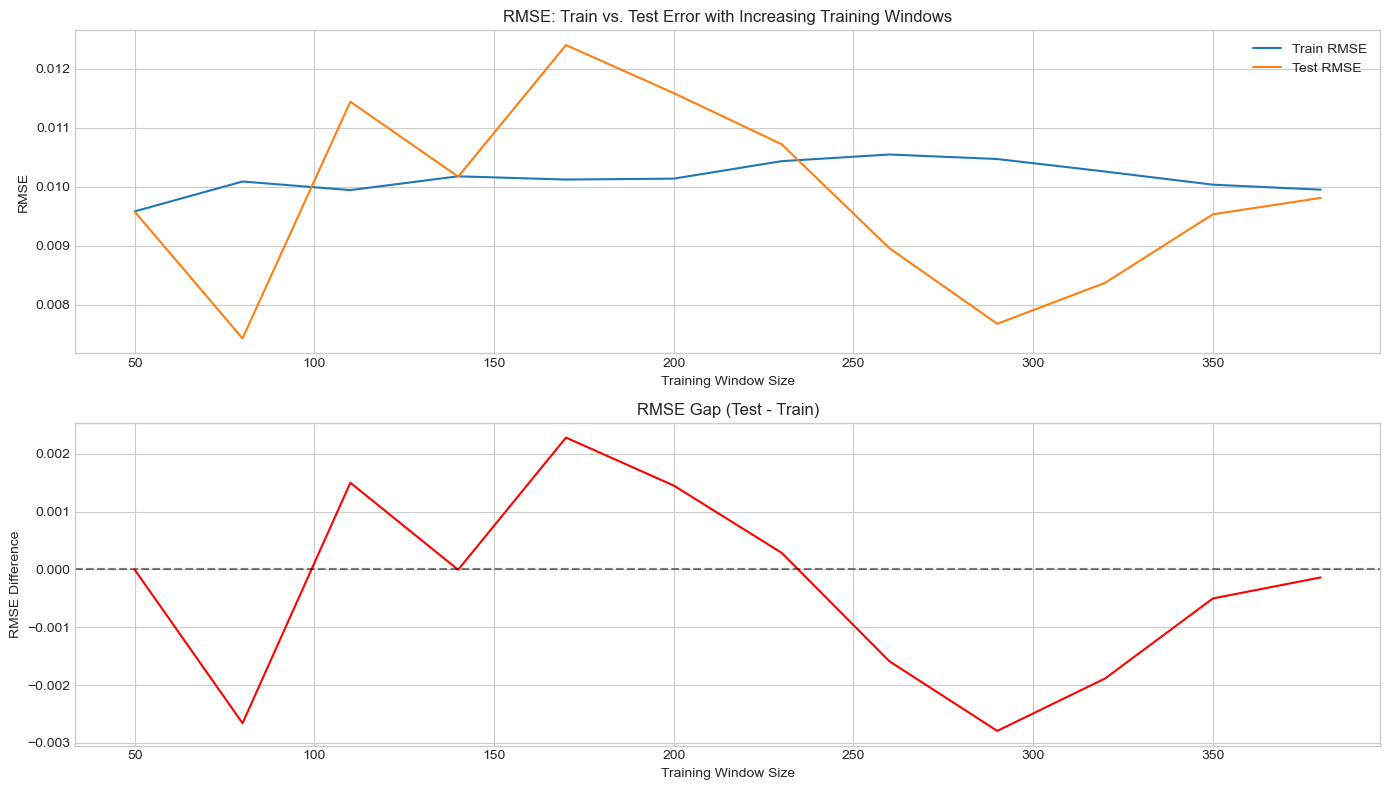

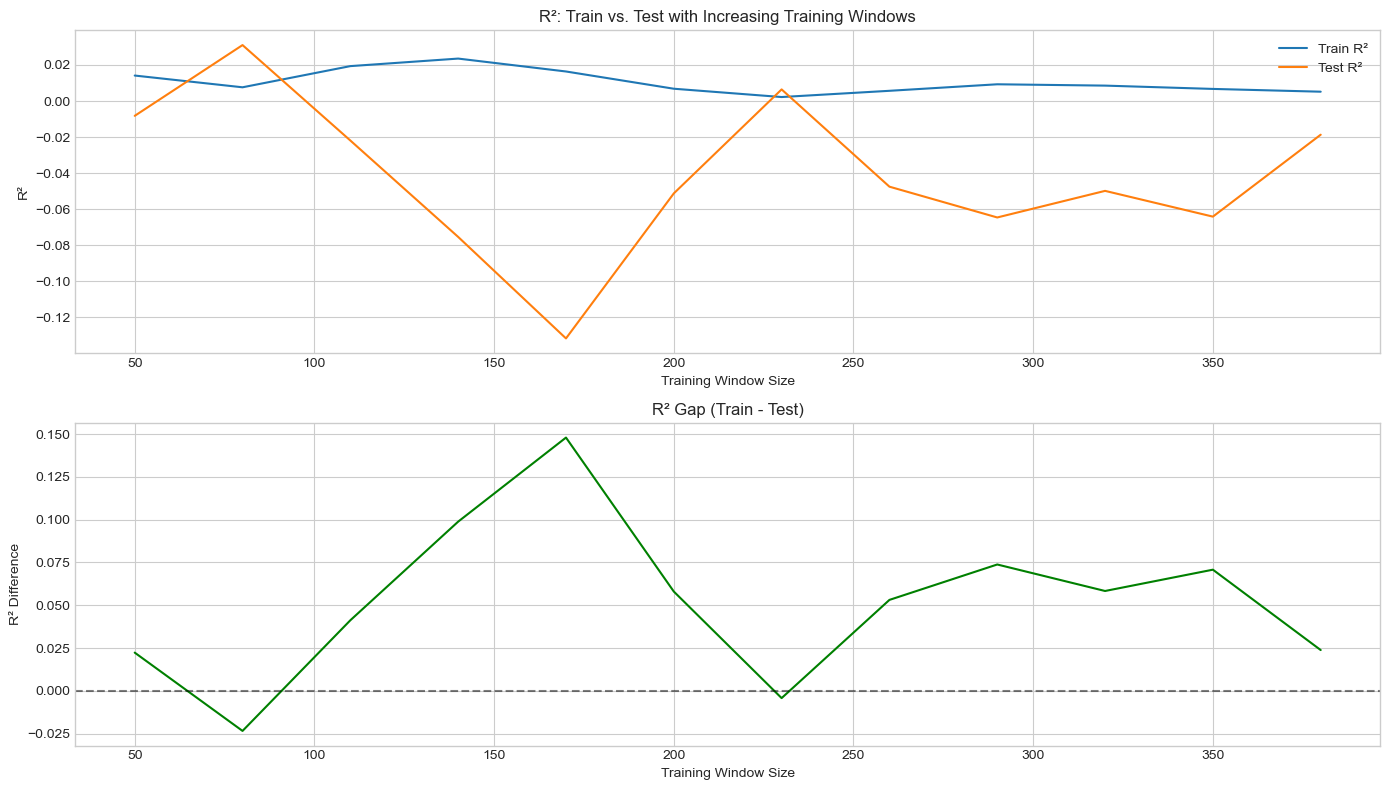

In [9]:
# Function to perform validation with increasing training window sizes
def analyze_train_test_gap(data, feature_cols, target_col, min_train_size=50, max_train_size=None, step=30):
    """
    Analyze the gap between training and testing errors with increasing training window sizes.
    
    Parameters:
    data (DataFrame): The dataset
    feature_cols (list): List of feature column names
    target_col (str): Target column name
    min_train_size (int): Minimum training window size
    max_train_size (int): Maximum training window size (default: 80% of data)
    step (int): Step size for increasing window
    
    Returns:
    DataFrame: DataFrame with window sizes and corresponding metrics
    """
    if max_train_size is None:
        max_train_size = int(len(data) * 0.8)
    
    results = []
    
    for window_size in range(min_train_size, max_train_size, step):
        # Split data
        train_data = data.iloc[:window_size]
        test_data = data.iloc[window_size:window_size+int(window_size*0.2)]  # Test on 20% of train size
        
        X_train = train_data[feature_cols]
        y_train = train_data[target_col]
        
        X_test = test_data[feature_cols]
        y_test = test_data[target_col]
        
        # Train model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        results.append({
            'Window Size': window_size,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'RMSE Gap': test_rmse - train_rmse,
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'MAE Gap': test_mae - train_mae,
            'Train R2': train_r2,
            'Test R2': test_r2,
            'R2 Gap': train_r2 - test_r2
        })
    
    return pd.DataFrame(results)

# Perform the analysis
gap_analysis = analyze_train_test_gap(df_returns, available_cols, 'Returns')

print("Train-vs-Test Error Gap Analysis:")
print(gap_analysis)

# Plot RMSE gap
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(gap_analysis['Window Size'], gap_analysis['Train RMSE'], label='Train RMSE')
plt.plot(gap_analysis['Window Size'], gap_analysis['Test RMSE'], label='Test RMSE')
plt.title('RMSE: Train vs. Test Error with Increasing Training Windows')
plt.xlabel('Training Window Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(gap_analysis['Window Size'], gap_analysis['RMSE Gap'], color='red')
plt.title('RMSE Gap (Test - Train)')
plt.xlabel('Training Window Size')
plt.ylabel('RMSE Difference')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot R² values
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(gap_analysis['Window Size'], gap_analysis['Train R2'], label='Train R²')
plt.plot(gap_analysis['Window Size'], gap_analysis['Test R2'], label='Test R²')
plt.title('R²: Train vs. Test with Increasing Training Windows')
plt.xlabel('Training Window Size')
plt.ylabel('R²')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(gap_analysis['Window Size'], gap_analysis['R2 Gap'], color='green')
plt.title('R² Gap (Train - Test)')
plt.xlabel('Training Window Size')
plt.ylabel('R² Difference')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Economic Metrics Evaluation

Let's evaluate the model using economic metrics such as directional accuracy and Sharpe ratio.

In [10]:
# Calculate directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate the directional accuracy of predictions
    
    Parameters:
    y_true (array): Actual values
    y_pred (array): Predicted values
    
    Returns:
    float: Directional accuracy (percentage)
    """
    # Convert to numpy arrays if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate direction of movement (up=1, down=0)
    true_direction = (y_true > 0).astype(int)
    pred_direction = (y_pred > 0).astype(int)
    
    # Calculate accuracy
    correct_directions = np.sum(true_direction == pred_direction)
    return correct_directions / len(y_true) * 100

# Calculate Sharpe ratio for a simple trading strategy
def calculate_sharpe(returns, predictions, risk_free_rate=0.0):
    """
    Calculate Sharpe ratio for a simple trading strategy
    
    Parameters:
    returns (array): Actual returns
    predictions (array): Predicted returns
    risk_free_rate (float): Risk-free rate (annual)
    
    Returns:
    float: Sharpe ratio (annualized)
    """
    # Create a simple strategy: long when predicted returns > 0, short otherwise
    strategy_returns = np.where(predictions > 0, returns, -returns)
    
    # Calculate annualized Sharpe ratio (assuming daily returns)
    mean_return = np.mean(strategy_returns)
    std_return = np.std(strategy_returns)
    
    if std_return == 0:
        return 0
        
    # Annualize (assuming 252 trading days)
    sharpe = (mean_return - risk_free_rate / 252) / std_return * np.sqrt(252)
    return sharpe

# Apply economic metrics to our walk-forward validation results
dir_accuracy = directional_accuracy(actuals, predictions)
sharpe = calculate_sharpe(actuals, predictions)

print(f"Directional Accuracy: {dir_accuracy:.2f}%")
print(f"Sharpe Ratio: {sharpe:.4f}")

# Create a simple trading strategy based on predictions
# 1 = long, -1 = short, 0 = no position
strategy_positions = np.where(np.array(predictions) > 0, 1, -1)

# Calculate strategy returns
strategy_returns = strategy_positions * np.array(actuals)
market_returns = np.array(actuals)  # Buy and hold returns

# Calculate cumulative returns
cumulative_strategy = (1 + strategy_returns).cumprod() - 1
cumulative_market = (1 + market_returns).cumprod() - 1

# Plot strategy performance
plt.figure(figsize=(14, 7))
plt.plot(test_indices, cumulative_strategy * 100, label='Trading Strategy')
plt.plot(test_indices, cumulative_market * 100, label='Buy and Hold')
plt.title('Cumulative Returns: Strategy vs Buy-and-Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate additional economic metrics
win_rate = np.sum(strategy_returns > 0) / len(strategy_returns) * 100
avg_win = np.mean(strategy_returns[strategy_returns > 0])
avg_loss = np.mean(strategy_returns[strategy_returns < 0])
profit_factor = -np.sum(strategy_returns[strategy_returns > 0]) / np.sum(strategy_returns[strategy_returns < 0]) if np.sum(strategy_returns[strategy_returns < 0]) != 0 else float('inf')

print(f"\nTrading Strategy Metrics:")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Win: {avg_win:.4f}")
print(f"Average Loss: {avg_loss:.4f}")
print(f"Profit Factor: {profit_factor:.4f}")
print(f"Final Strategy Return: {cumulative_strategy[-1]*100:.2f}%")
print(f"Final Buy-and-Hold Return: {cumulative_market[-1]*100:.2f}%")

TypeError: '>' not supported between instances of 'list' and 'int'

## Conclusion

In this notebook, we addressed several issues with linear regression models for stock price prediction:

1. **Non-stationarity**: We transformed price levels to returns to achieve stationarity.
2. **Data leakage**: We implemented proper feature shifting and walk-forward validation.
3. **Model evaluation**: We used both statistical metrics (RMSE, R²) and economic metrics (directional accuracy, Sharpe ratio).
4. **Overfitting**: We analyzed the train-test error gap to detect and address overfitting.

Key findings:
- Predicting returns rather than price levels improves model stationarity
- Walk-forward validation provides more realistic performance estimates
- Economic metrics are more relevant than statistical ones for trading decisions
- Simple models can sometimes outperform complex ones for financial time series

Next steps:
- Explore feature engineering to capture market regimes
- Test more sophisticated models like ARIMA, GARCH, or machine learning approaches
- Incorporate transaction costs in economic evaluation
- Consider ensemble methods to improve robustness